In [1]:
import numpy as np
import pyart, pyproj
import pandas as pd
import os
import pickle as pkl


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



Read radar station coords and snow sensor data.

In [22]:
filepath = '/Users/james/Documents/datascience/coursework/metis/sea17_ds1/student_submissions/projects/05-kojak/cho_james/old_snow/'
filename = 'rdr_coords.pkl'
with open(filepath + filename, 'rb') as handle:
    rdr_coords = pkl.load(handle)
    
filename = 'sr_df.pkl'
with open(filepath + filename, 'rb') as handle:
    snow = pkl.load(handle)

Get properties at a point

In [2]:
# https://groups.google.com/forum/#!searchin/pyart-users/find_x_y_displacement/pyart-users/NYRAKvv1R9A/RVup7ohZAwAJ

def find_x_y_displacement(radar, longitude, latitude):
    """ Return the x and y displacement (in meters) from a radar location. """
    # longitude and latitude in degrees
    lat_0 = radar.latitude['data'][0]
    lon_0 = radar.longitude['data'][0]
    proj = pyproj.Proj(proj='aeqd', lon_0=lon_0, lat_0=lat_0)
    return proj(longitude, latitude)


def find_nearest_gate(radar, longitude, latitude, altitude):
    """ Return the indices of the nearest gate to a given point. """
    # longitude and latitude in degrees, altitude in meters
    gate_x = radar.gate_x['data']
    gate_y = radar.gate_y['data']
    gate_z = radar.gate_z['data']

    x_disp, y_disp = find_x_y_displacement(radar, longitude, latitude)
    
    distances = np.sqrt(
        (gate_x-x_disp)**2. + (gate_y-y_disp)**2. + (gate_z-altitude)**2.)
    return np.unravel_index(distances.argmin(), distances.shape)

def interpolate_single_point(radar, longitude, latitude, altitude):
    """ Interpolate a single grid point at a given location. """
    x_disp, y_disp = find_x_y_displacement(radar, longitude, latitude)
    # grid dimension from center
    grid_h = 2000.0
    grid_alt = 150.0
    grid = pyart.map.grid_from_radars(
        (radar,),
        gridding_algo='map_gates_to_grid',
        grid_shape=(1, 1, 1),
        grid_limits=((altitude-grid_alt, altitude + grid_alt), (y_disp-grid_h, y_disp+grid_h), (x_disp-grid_h, x_disp+grid_h)),
        #grid_limits=((altitude, 0), (y_disp, 25000.0), (x_disp, 25000.0)),
        fields=['reflectivity', 'differential_phase', 'cross_correlation_ratio', 'velocity'])
    return grid

def get_reflectivity(radar, longitude, latitude, altitude):
    interpolate_single_point(radar, longitude, latitude, altitude)
    # interpolate around gate
    grid = interpolate_single_point(radar, longitude, latitude, altitude)
    #pyart.io.add_2d_latlon_axis(grid)
    pixel_latitude = grid.get_point_longitude_latitude()[1][0][0]
    pixel_longitude = grid.get_point_longitude_latitude()[0][0][0]
    #pixel_altitude = grid.axes['z_disp']['data'][0]
    pixel_reflectivity = np.asarray(grid.fields['reflectivity']['data'][0])[0][0]
    pixel_difphase = np.asarray(grid.fields['differential_phase']['data'][0])[0][0]
    pixel_xcorr_ratio = np.asarray(grid.fields['cross_correlation_ratio']['data'][0])[0][0]
    pixel_velocity = np.asarray(grid.fields['velocity']['data'][0])[0][0]
    
    # get time
    ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
    coverage_start_time = pd.to_datetime(radar.time['units'].strip("seconds since")) 
    ray_delta_time = pd.Timedelta(str(round(radar.time['data'][ray])) + ' seconds')
    ray_time = coverage_start_time + ray_delta_time
    
    return {'time': ray_time, 'lat': pixel_latitude, 'lon': pixel_longitude, 
            'alt_m': float(dict(grid.point_altitude)['data']), 
            'refl': pixel_reflectivity,
            'difphase': pixel_difphase,
            'xcorr_ratio': pixel_xcorr_ratio,
            'velocity': pixel_velocity
           }


def get_reflectivity_gate(radar, longitude, latitude, altitude):
    ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
    
    gate_latitude = radar.gate_latitude['data'][ray, gate]
    gate_longitude = radar.gate_longitude['data'][ray, gate]
    gate_altitude = radar.gate_altitude['data'][ray, gate]
    gate_reflectivity = radar.fields['reflectivity']['data'][ray, gate]
    
    coverage_start_time = pd.to_datetime(radar.time['units'].strip("seconds since")) 
    ray_delta_time = pd.Timedelta(str(round(radar.time['data'][ray])) + ' seconds')
    ray_time = coverage_start_time + ray_delta_time
    
    return {'time': ray_time, 'lat': gate_latitude, 'lon': gate_longitude,
            'alt_m': gate_altitude,'refl': gate_reflectivity}
    

#####

# latitude = 37.0    # latitude (in degrees) to find reflectivity at or near
# longitude = -120.0  # longitude (in degrees) to find reflectivity at or near
# altitude = 6000       # altitude (in meters) to find reflectivity at or near

# # find nearest gate
# ray, gate = find_nearest_gate(radar, longitude, latitude, altitude)
# #print(ray, gate)
# gate_latitude = radar.gate_latitude['data'][ray, gate]
# gate_longitude = radar.gate_longitude['data'][ray, gate]
# gate_altitude = radar.gate_altitude['data'][ray, gate]
# gate_reflectivity = radar.fields['reflectivity']['data'][ray, gate]
# print("-----------------------")
# print("Nearest gate:")
# print("Latitude:", gate_latitude)
# print("Longitude:", gate_longitude)
# print("Altitude:", gate_altitude)
# print("Reflectivity:", gate_reflectivity)

# # interpolate around gate
# grid = interpolate_single_point(radar, longitude, latitude, altitude)
# #pyart.io.add_2d_latlon_axis(grid)
# pixel_latitude = grid.get_point_longitude_latitude()[1][0][0]
# pixel_longitude = grid.get_point_longitude_latitude()[0][0][0]
# #pixel_altitude = grid.axes['z_disp']['data'][0]
# pixel_reflectivity = np.asarray(grid.fields['reflectivity']['data'][0])[0][0]

# # get time of reading
# coverage_start_time = pd.to_datetime(radar.time['units'].strip("seconds since")) 
# ray_delta_time = pd.Timedelta(str(round(radar.time['data'][ray])) + ' seconds')
# ray_time = coverage_start_time + ray_delta_time

# print("-----------------------")
# print("Interpolated pixel:")
# print("Latitude:", pixel_latitude)
# print("Longitude:", pixel_longitude)
# #print("Altitude:", pixel_altitude[0][0])
# print("Reflectivity:", pixel_reflectivity)
# print("Ray time", ray_time)


Did it for one point. Now, for one snow sensor station, get all readings and times from all radar files

In [25]:
import os
# build filename list
filepath = '/Users/james/Documents/datascience/coursework/metis/sea17_ds1/student_submissions/projects/05-kojak/cho_james/old_snow/new_data/'
os.chdir(filepath)
rdr = 'KHNX'
files = tuple(filter(lambda s: rdr == s[:4], os.listdir()))


In [26]:
files

('KHNXd20170115t0000.cfradial',
 'KHNXd20170115t0200.cfradial',
 'KHNXd20170115t0400.cfradial',
 'KHNXd20170115t0600.cfradial',
 'KHNXd20170115t0800.cfradial',
 'KHNXd20170115t1000.cfradial',
 'KHNXd20170115t1200.cfradial',
 'KHNXd20170115t1400.cfradial',
 'KHNXd20170115t1600.cfradial',
 'KHNXd20170115t1800.cfradial',
 'KHNXd20170115t2000.cfradial',
 'KHNXd20170115t2200.cfradial',
 'KHNXd20170116t0000.cfradial',
 'KHNXd20170116t0200.cfradial',
 'KHNXd20170116t0400.cfradial',
 'KHNXd20170116t0600.cfradial',
 'KHNXd20170116t0800.cfradial',
 'KHNXd20170116t1000.cfradial',
 'KHNXd20170116t1200.cfradial',
 'KHNXd20170116t1400.cfradial',
 'KHNXd20170116t1600.cfradial',
 'KHNXd20170116t1800.cfradial',
 'KHNXd20170116t2000.cfradial',
 'KHNXd20170116t2200.cfradial',
 'KHNXd20170117t0000.cfradial',
 'KHNXd20170117t0200.cfradial',
 'KHNXd20170117t0400.cfradial',
 'KHNXd20170117t0600.cfradial',
 'KHNXd20170117t0800.cfradial',
 'KHNXd20170117t1000.cfradial',
 'KHNXd20170117t1200.cfradial',
 'KHNXd2

In [19]:
st_list

['agp',
 'bgp',
 'bsh',
 'chp',
 'dan',
 'frw',
 'gem',
 'ksp',
 'mhp',
 'slk',
 'stl',
 'swm',
 'tum',
 'tun',
 'ubc',
 'vlc',
 'wtm',
 'wwc']

In [27]:
%%time
from IPython.display import clear_output
from datetime import datetime
import gc

# pass station code list, file list
#st_codes = ['gnf','grm'] # sensor code

st_codes = st_list

refl = {'st_code': [],
        'alt_m':[], 
        'lat':[], 
        'lon':[], 
        'refl':[], 
        'difphase':[], 
        'xcorr_ratio':[], 
        'velocity': [], 
        'time':[]}
# KHNXd20170118t2200.cfradial
for i,filename in enumerate(files):
    print('\n\n-------------------------')
    print("Reading", filename, i+1, 'of', len(files), 'files')
    print(datetime.now())
    radar = pyart.io.read_cfradial(filepath + filename, delay_field_loading=True)
    altitudes = range(2000,6001,1000) # in meters. 6500 to 20000 ft
    refl_alt = []
    old_ref = 0
    new_ref = 0
    for st_code in st_codes:
        lat = snow[snow['st_code'] == st_code].head(1)['st_lat']
        lon = snow[snow['st_code'] == st_code].head(1)['st_lon']

        print("\nsensor:", st_code)
        for alt in altitudes:
            print('altitude:', alt, 'm')
            new_ref = get_reflectivity(radar, float(lon), float(lat), alt)
            new_ref['st_code'] = st_code
            #new_ref = get_reflectivity_gate(radar, float(lon), float(lat), alt)
            if new_ref != old_ref:
                for k in refl.keys():
                    refl[k].append(new_ref[k]) # should have some "reading code for sensors"
            old_ref = new_ref
    pd.DataFrame.from_dict(refl).to_pickle('refl2_df.pkl')
    del radar
    if i > 0 and i % 5 == 0:
        gc.collect()
        clear_output()




-------------------------
Reading KHNXd20170207t2000.cfradial 287 of 288 files
2017-09-07 21:10:47.417271

sensor: agp
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: bgp
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: bsh
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: chp
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: dan
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: frw
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: gem
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: ksp
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: mhp
altitude: 2000 m
altitude: 3000 m
altitude: 4000 m
altitude: 5000 m
altitude: 6000 m

sensor: s

### Review sensor data

In [3]:
sr_df = pd.read_pickle('sr_df.pkl')

In [4]:
srr_df = sr_df[sr_df['r_closest'] == 'khnx'].reset_index()
srr_df.drop('index', axis=1, inplace=True)

In [5]:
# convert everything to metric

srr_df['elev_m'] = srr_df['elev_ft'] * 0.305
srr_df['today_mm'] = srr_df['today_in'] * 25.4
srr_df['r_elev_delta_m'] = srr_df['r_elev_delta_ft'] * 0.305

del srr_df['elev_ft'], srr_df['today_in'], srr_df['r_elev_delta_ft']

In [6]:
srr_df.head()

,st_code,date,st_lat,st_lon,r_closest,r_dist_km,elev_m,today_mm,r_elev_delta_m
0,dan,2017-01-01,37.897,-119.257,khnx,178.800053,2989.00,289.56,2914.885
1,tum,2017-01-01,37.873,-119.350,khnx,174.808083,2623.00,149.86,2548.885
2,tny,2017-01-01,37.838,-119.448,khnx,169.905072,2485.75,279.40,2411.635
3,whw,2017-01-01,37.859,-119.652,khnx,171.453515,2409.50,177.80,2335.385
4,vlc,2017-01-01,37.388,-118.903,khnx,135.758668,3065.25,325.12,2991.135


In [7]:
srr_grouped = srr_df.groupby('st_code')

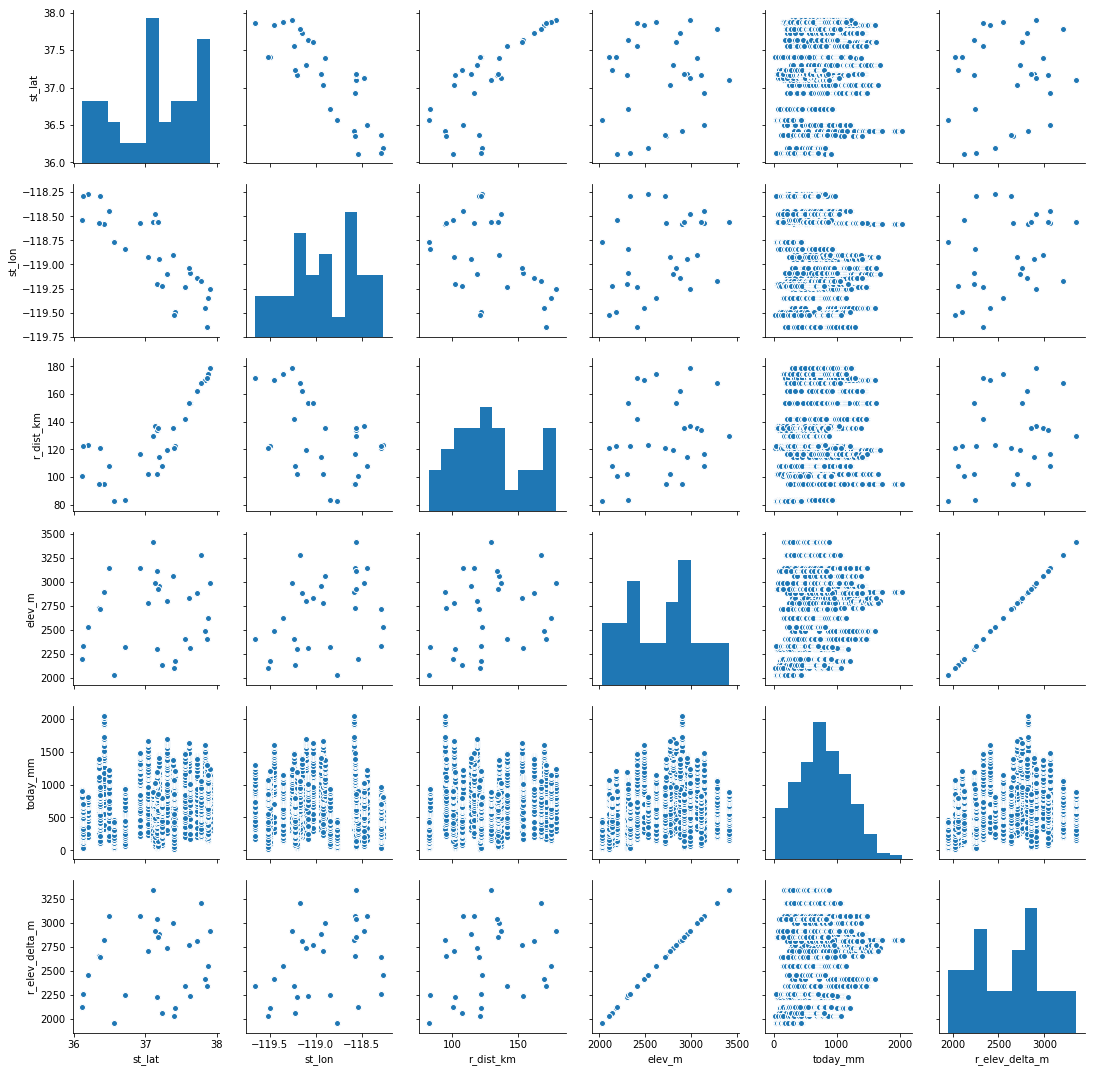

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(srr_df)
plt.show()

/Users/james/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


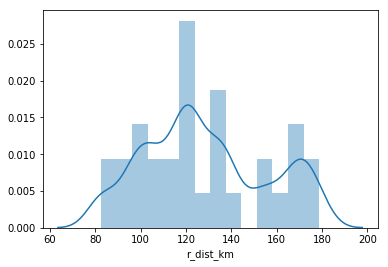

In [13]:
sns.distplot(srr_df['r_dist_km'])
plt.show()

/Users/james/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


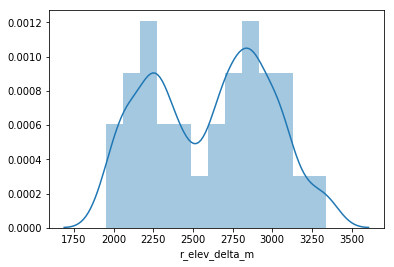

In [14]:
sns.distplot(srr_df['r_elev_delta_m'])
plt.show()

In [11]:
st_list = tuple(srr_df[srr_df.r_elev_delta_m < 99999].groupby('st_code').groups.keys())
num_files = 288
num_stations = len(st_list)
h = num_files*(5 + 15*num_stations)/3600
print(h, 'hours to read files')
print(st_list)
# for one file
# extract points ?

37.6 hours to read files
('agp', 'bch', 'bgp', 'bim', 'bsh', 'chm', 'chp', 'csv', 'dan', 'dpo', 'frw', 'gem', 'gnf', 'grm', 'hnt', 'ksp', 'mhp', 'psr', 'qua', 'slk', 'stl', 'swm', 'tmr', 'tny', 'tum', 'tun', 'ubc', 'vlc', 'whw', 'wtm', 'wwc')


In [15]:
st_list = [st for st in st_list if st not in st_list_old]

In [16]:
st_list

['agp',
 'bgp',
 'bsh',
 'chp',
 'dan',
 'frw',
 'gem',
 'ksp',
 'mhp',
 'slk',
 'stl',
 'swm',
 'tum',
 'tun',
 'ubc',
 'vlc',
 'wtm',
 'wwc']

In [193]:
pd.to_pickle

<function pandas.io.pickle.to_pickle>